In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
np.random.seed(42)

# Study population

In [3]:
data_dir = '../datafiles/mimic/'

In [4]:
metadata_df = pd.read_csv(data_dir + 'mimic-cxr-2.0.0-metadata.csv')
diagnosis_df = pd.read_csv(data_dir + 'mimic-cxr-2.0.0-chexpert.csv')
admissions_df = pd.read_csv(data_dir + 'admissions.csv')
patients_df = pd.read_csv(data_dir + 'patients.csv')

In [5]:
metadata_df.head()

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,CHEST (PA AND LAT),LATERAL,3056,2544,21800506,213014.531,CHEST (PA AND LAT),lateral,Erect
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,CHEST (PA AND LAT),LATERAL,3056,2544,21800626,165500.312,CHEST (PA AND LAT),lateral,Erect
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN


In [6]:
print("Number of images: " + str(len(metadata_df)))
print("Number of patients: " + str(metadata_df.subject_id.nunique()))

Number of images: 377110
Number of patients: 65379


In [7]:
admissions_df.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,14679932,21038362,2139-09-26 14:16:00,2139-09-28 11:30:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,SINGLE,UNKNOWN,NaN,NaN,0
1,15585972,24941086,2123-10-07 23:56:00,2123-10-12 11:22:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,WHITE,NaN,NaN,0
2,11989120,21965160,2147-01-14 09:00:00,2147-01-17 14:25:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,UNKNOWN,NaN,NaN,0
3,17817079,24709883,2165-12-27 17:33:00,2165-12-31 21:18:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,OTHER,NaN,NaN,0
4,15078341,23272159,2122-08-28 08:48:00,2122-08-30 12:32:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,0


In [8]:
admissions_df.ethnicity.value_counts()

WHITE                            337630
BLACK/AFRICAN AMERICAN            80293
HISPANIC/LATINO                   29823
OTHER                             26813
ASIAN                             24506
UNKNOWN                           19400
UNABLE TO OBTAIN                   3740
AMERICAN INDIAN/ALASKA NATIVE      1535
Name: ethnicity, dtype: int64

In [9]:
# remove patients who have inconsistent documented race information
# credit to github.com/robintibor
ethnicity_df = admissions_df.loc[:,['subject_id', 'ethnicity']].drop_duplicates()

v = ethnicity_df.subject_id.value_counts()
subject_id_more_than_once = v.index[v.gt(1)]

ambiguous_ethnicity_df = ethnicity_df[ethnicity_df.subject_id.isin(subject_id_more_than_once)]
inconsistent_race = ambiguous_ethnicity_df.subject_id.unique()

grouped = ambiguous_ethnicity_df.groupby('subject_id')
grouped.aggregate(lambda x: "_".join(sorted(x))).ethnicity.value_counts()

OTHER_WHITE                                                   2489
UNKNOWN_WHITE                                                 1131
BLACK/AFRICAN AMERICAN_OTHER                                   560
UNABLE TO OBTAIN_WHITE                                         308
HISPANIC/LATINO_OTHER                                          307
HISPANIC/LATINO_WHITE                                          204
HISPANIC/LATINO_UNKNOWN                                        173
BLACK/AFRICAN AMERICAN_WHITE                                   168
BLACK/AFRICAN AMERICAN_UNKNOWN                                 156
OTHER_UNKNOWN                                                  130
BLACK/AFRICAN AMERICAN_HISPANIC/LATINO                         111
ASIAN_OTHER                                                     98
UNABLE TO OBTAIN_UNKNOWN                                        49
ASIAN_WHITE                                                     46
BLACK/AFRICAN AMERICAN_UNABLE TO OBTAIN                       

In [10]:
merge_df = pd.merge(metadata_df,diagnosis_df,on=['subject_id', 'study_id'])
merge_df = pd.merge(merge_df,ethnicity_df,on='subject_id')
merge_df = merge_df[~merge_df.subject_id.isin(inconsistent_race)]
merge_df = merge_df.rename(columns={"ethnicity": "race"})
merge_df = merge_df[merge_df.race.isin(['ASIAN','BLACK/AFRICAN AMERICAN','WHITE'])]
merge_df = merge_df[merge_df.ViewPosition.isin(['AP','PA'])]

In [11]:
df_cxr = pd.merge(merge_df,patients_df, on='subject_id')

In [12]:
print("Total images after inclusion/exclusion criteria: " + str(len(df_cxr)))
print("Total patients after inclusion/exclusion criteria: " + str(df_cxr.subject_id.nunique()))

Total images after inclusion/exclusion criteria: 183207
Total patients after inclusion/exclusion criteria: 43209


In [13]:
df_cxr = df_cxr.rename(columns={'gender': 'sex'})
df_cxr = df_cxr.rename(columns={'anchor_age': 'age'})

study_year = np.floor(df_cxr['StudyDate'] / 10000)
delta_years = study_year - df_cxr['anchor_year']
df_cxr['age'] = df_cxr['age'] + delta_years

In [14]:
white = 'White'
asian = 'Asian'
black = 'Black'

In [15]:
mask = (df_cxr.race.str.contains("BLACK", na=False))
df_cxr.loc[mask, "race"] = black

mask = (df_cxr.race.str.contains("WHITE", na=False))
df_cxr.loc[mask, "race"] = white

mask = (df_cxr.race.str.contains("ASIAN", na=False))
df_cxr.loc[mask, "race"] = asian

df_cxr['race'].unique()

array(['White', 'Black', 'Asian'], dtype=object)

In [16]:
df_cxr = df_cxr[df_cxr.race.isin([asian,black,white])]

In [17]:
df_cxr['race_label'] = df_cxr['race']

df_cxr.loc[df_cxr['race_label'] == white, 'race_label'] = 0
df_cxr.loc[df_cxr['race_label'] == asian, 'race_label'] = 1
df_cxr.loc[df_cxr['race_label'] == black, 'race_label'] = 2

In [18]:
df_cxr.loc[df_cxr['sex'] == 'F', 'sex'] = 'Female'
df_cxr.loc[df_cxr['sex'] == 'M', 'sex'] = 'Male'

In [19]:
df_cxr['sex_label'] = df_cxr['sex']

df_cxr.loc[df_cxr['sex_label'] == 'Male', 'sex_label'] = 0
df_cxr.loc[df_cxr['sex_label'] == 'Female', 'sex_label'] = 1

In [20]:
df_cxr['sex'].unique()

array(['Female', 'Male'], dtype=object)

In [21]:
df_cxr.head()

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,...,Pneumothorax,Support Devices,race,sex,age,anchor_year,anchor_year_group,dod,race_label,sex_label
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,CHEST (PA AND LAT),...,NaN,NaN,White,Female,52.0,2180,2014 - 2016,NaN,0,1
1,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,CHEST (PA AND LAT),...,NaN,NaN,White,Female,52.0,2180,2014 - 2016,NaN,0,1
2,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,CHEST (PORTABLE AP),...,NaN,NaN,White,Female,52.0,2180,2014 - 2016,NaN,0,1
3,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,10000032,53911762,CHEST (PORTABLE AP),AP,2906,2258,21800723,80556.875,CHEST (PORTABLE AP),...,NaN,NaN,White,Female,52.0,2180,2014 - 2016,NaN,0,1
4,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,10000032,56699142,CHEST (PORTABLE AP),AP,3056,2544,21800805,234424.765,CHEST (PORTABLE AP),...,NaN,NaN,White,Female,52.0,2180,2014 - 2016,NaN,0,1


In [22]:
labels = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices']

In [23]:
df_cxr['disease'] = df_cxr[labels[0]]
df_cxr.loc[df_cxr[labels[0]] == 1, 'disease'] = labels[0]
df_cxr.loc[df_cxr[labels[10]] == 1, 'disease'] = labels[10]
df_cxr.loc[df_cxr['disease'].isna(), 'disease'] = 'Other'

df_cxr['disease_label'] = df_cxr['disease']
df_cxr.loc[df_cxr['disease_label'] == labels[0], 'disease_label'] = 0
df_cxr.loc[df_cxr['disease_label'] == labels[10], 'disease_label'] = 1
df_cxr.loc[df_cxr['disease_label'] == 'Other', 'disease_label'] = 2

In [24]:
df_cxr.subject_id = df_cxr.subject_id.astype(str)
df_cxr.study_id = df_cxr.study_id.astype(str)
df_cxr.insert(2, "path", "")
df_cxr.path = df_cxr.subject_id.str[0:2]
df_cxr.path = "p" + df_cxr.path
df_cxr.path = df_cxr.path + "/p" + df_cxr.subject_id + "/s" + df_cxr.study_id + "/" + df_cxr.dicom_id + ".jpg"

In [25]:
df_cxr.head()

,dicom_id,subject_id,path,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,...,race,sex,age,anchor_year,anchor_year_group,dod,race_label,sex_label,disease,disease_label
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,p10/p10000032/s50414267/02aa804e-bde0afdd-112c...,50414267,CHEST (PA AND LAT),PA,3056,2544,21800506,213014.531,...,White,Female,52.0,2180,2014 - 2016,NaN,0,1,No Finding,0
1,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,p10/p10000032/s53189527/2a2277a9-b0ded155-c0de...,53189527,CHEST (PA AND LAT),PA,3056,2544,21800626,165500.312,...,White,Female,52.0,2180,2014 - 2016,NaN,0,1,No Finding,0
2,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,53911762,CHEST (PORTABLE AP),AP,2705,2539,21800723,80556.875,...,White,Female,52.0,2180,2014 - 2016,NaN,0,1,No Finding,0
3,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,10000032,p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...,53911762,CHEST (PORTABLE AP),AP,2906,2258,21800723,80556.875,...,White,Female,52.0,2180,2014 - 2016,NaN,0,1,No Finding,0
4,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,10000032,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,56699142,CHEST (PORTABLE AP),AP,3056,2544,21800805,234424.765,...,White,Female,52.0,2180,2014 - 2016,NaN,0,1,No Finding,0


### Pre-processing of imaging dataset (this may take a few hours, needed only once)

In [ ]:
img_data_dir = '<path_to_imaging_data>'

In [ ]:
from skimage.io import imread
from skimage.io import imsave
from skimage.transform import resize

df_cxr['path_preproc'] = df_cxr['path']

preproc_dir = 'preproc_224x224/'
out_dir = img_data_dir

if not os.path.exists(out_dir + preproc_dir):
    os.makedirs(out_dir + preproc_dir)

for idx, p in enumerate(tqdm(df_cxr['path'])):

    split =  p.split("/")
    preproc_filename = split[2] + '_'+ split[3]
    df_cxr.loc[idx, 'path_preproc'] = preproc_dir + preproc_filename
    out_path = out_dir + preproc_dir + preproc_filename
    
    if not os.path.exists(out_path):
        image = imread(img_data_dir + p)
        image = resize(image, output_shape=(224, 224), preserve_range=True)
        imsave(out_path, image.astype(np.uint8))

### Random splitting into train, validation, test

In [ ]:
df_cxr.insert(5, "split","none", True)
unique_sub_id = df_cxr.subject_id.unique()

train_percent, valid_percent, test_percent = 0.60, 0.10, 0.30

unique_sub_id = shuffle(unique_sub_id)
value1 = (round(len(unique_sub_id)*train_percent))
value2 = (round(len(unique_sub_id)*valid_percent))
value3 = value1 + value2
value4 = (round(len(unique_sub_id)*test_percent))

In [ ]:
print("Patients in training set: " + str(value1))

In [ ]:
print("Patients in validation set: " + str(value2))

In [ ]:
print("Patients in testing set: " + str(value4))

In [ ]:
df_cxr = shuffle(df_cxr)

train_sub_id = unique_sub_id[:value1]
validate_sub_id = unique_sub_id[value1:value3]
test_sub_id = unique_sub_id[value3:]

In [ ]:
df_cxr.loc[df_cxr.subject_id.isin(train_sub_id), "split"]="train"
df_cxr.loc[df_cxr.subject_id.isin(validate_sub_id), "split"]="validate"
df_cxr.loc[df_cxr.subject_id.isin(test_sub_id), "split"]="test"

In [ ]:
df_cxr.split.value_counts(normalize=True)

In [ ]:
df_cxr.split.value_counts(normalize=False)

### Save full sample

In [ ]:
df_cxr.to_csv(data_dir + 'mimic.sample.csv')

## Creating subsets

In [26]:
df_cxr = pd.read_csv(data_dir + 'mimic.sample.csv')

In [27]:
df_train = df_cxr[df_cxr.split=="train"]
df_val = df_cxr[df_cxr.split=="validate"]
df_test = df_cxr[df_cxr.split=="test"]

In [ ]:
df_train.to_csv(data_dir + 'mimic.sample.train.csv')
df_val.to_csv(data_dir + 'mimic.sample.val.csv')
df_test.to_csv(data_dir + 'mimic.sample.test.csv')

In [ ]:
df_train_white = df_train[df_train['race'] == white]
df_val_white = df_val[df_val['race'] == white]
df_train_white.to_csv(data_dir + 'mimic.sample.train.white.csv')
df_val_white.to_csv(data_dir + 'mimic.sample.val.white.csv')

df_cxr_white = df_cxr[df_cxr['race'] == white]
df_cxr_asian = df_cxr[df_cxr['race'] == asian]
df_cxr_black = df_cxr[df_cxr['race'] == black]

df_test_white = df_test[df_test['race'] == white]
df_test_asian = df_test[df_test['race'] == asian]
df_test_black = df_test[df_test['race'] == black]

df_train_asian = df_train[df_train['race'] == asian]
df_train_black = df_train[df_train['race'] == black]

df_val_asian = df_val[df_val['race'] == asian]
df_val_black = df_val[df_val['race'] == black]

In [ ]:
df_train_male = df_train[df_train['sex'] == 'Male']
df_val_male = df_val[df_val['sex'] == 'Male']
df_train_male.to_csv(data_dir + 'mimic.sample.train.male.csv')
df_val_male.to_csv(data_dir + 'mimic.sample.val.male.csv')

## Plots

In [28]:
df_cxr.loc[df_cxr['disease'] == 'Pleural Effusion', 'disease'] = 'Pleur. Eff.'
df_cxr.loc[df_cxr['disease'] == 'No Finding', 'disease'] = 'No Find.'

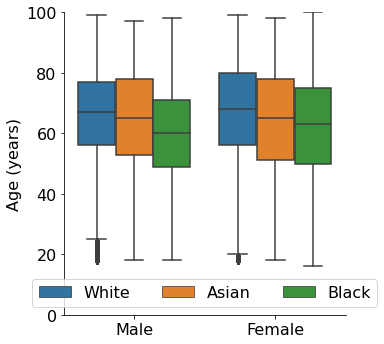

In [29]:
fontsize = 16
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)
fig = sns.catplot(x='sex', y='age', hue='race', order=['Male', 'Female'], hue_order=['White', 'Asian', 'Black'], kind="box", data=df_cxr)
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.legend(fontsize=fontsize, loc='lower center', ncol=3)
plt.show()
# fig.savefig("MIMIC-age-sex-race.png", bbox_inches='tight', dpi=300)

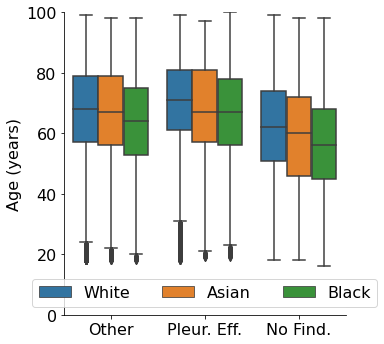

In [30]:
fig = sns.catplot(x='disease', y='age', hue='race', order=['Other', 'Pleur. Eff.', 'No Find.'], hue_order=['White', 'Asian', 'Black'], kind="box", data=df_cxr)
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.legend(fontsize=fontsize, loc='lower center', ncol=3)
plt.show()
# fig.savefig("MIMIC-age-pathology-race.png", bbox_inches='tight', dpi=300)

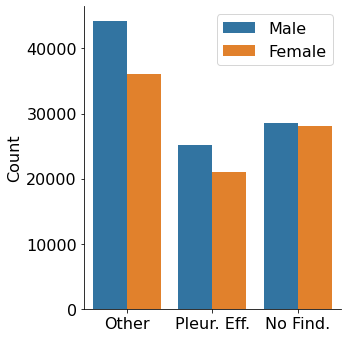

In [31]:
fig = sns.catplot(x='disease', hue='sex', order=['Other', 'Pleur. Eff.', 'No Find.'], hue_order=['Male', 'Female'], data=df_cxr, kind='count')
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()
# fig.savefig("MIMIC-sex-pathology.png", bbox_inches='tight', dpi=300)

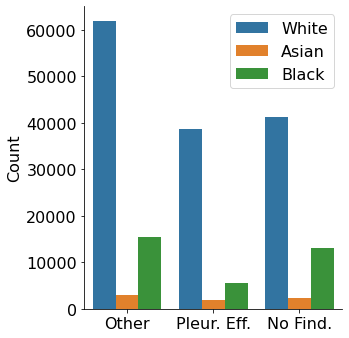

In [32]:
fig = sns.catplot(x='disease', hue='race', order=['Other', 'Pleur. Eff.', 'No Find.'], hue_order=['White', 'Asian', 'Black'], data=df_cxr, kind='count')
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()
# fig.savefig("MIMIC-race-pathology.png", bbox_inches='tight', dpi=300)

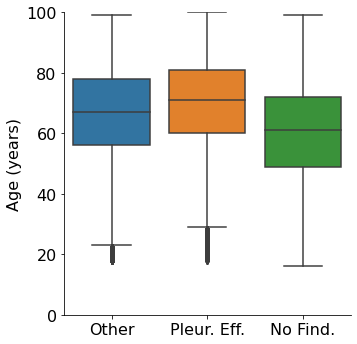

In [33]:
fig = sns.catplot(x='disease', y='age', order=['Other', 'Pleur. Eff.', 'No Find.'], kind="box", data=df_cxr)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.show()
# fig.savefig("MIMIC-age-pathology.png", bbox_inches='tight', dpi=300)

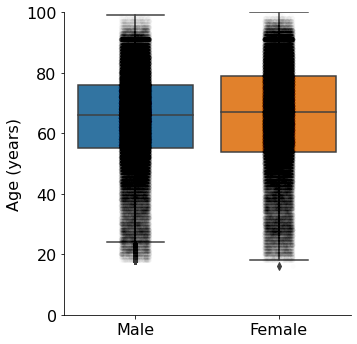

In [34]:
fig = sns.catplot(x='sex', y='age', order=['Male', 'Female'], kind="box", data=df_cxr)
sns.stripplot(x='sex', y='age', color='k', order=['Male', 'Female'], alpha=0.01, data=df_cxr, ax=fig.ax)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.show()
# fig.savefig("MIMIC-age-sex.png", bbox_inches='tight', dpi=300)

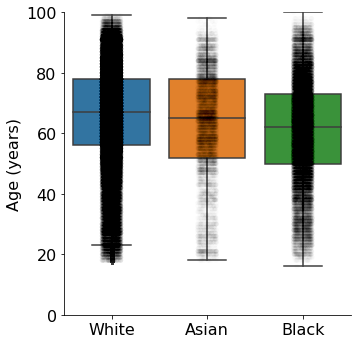

In [35]:
fig = sns.catplot(x='race', y='age', order=['White', 'Asian', 'Black'], kind="box", data=df_cxr)
sns.stripplot(x='race', y='age', color='k', order=['White', 'Asian', 'Black'], alpha=0.01, data=df_cxr, ax=fig.ax)
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Age (years)', fontsize=fontsize)
plt.ylim([0, 100])
plt.show()
# fig.savefig("MIMIC-age-race.png", bbox_inches='tight', dpi=300)

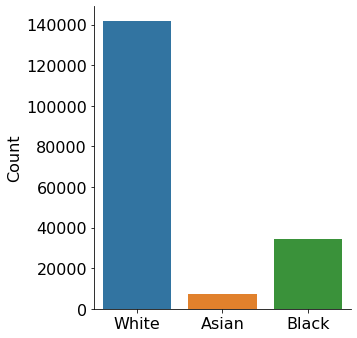

In [36]:
fig = sns.catplot(x='race', order=['White', 'Asian', 'Black'], data=df_cxr, kind='count')
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.show()
# fig.savefig("MIMIC-race.png", bbox_inches='tight', dpi=300)

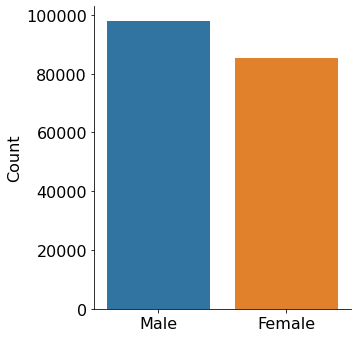

In [37]:
fig = sns.catplot(x='sex', order=['Male', 'Female'], data=df_cxr, kind='count')
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.show()
# fig.savefig("MIMIC-sex.png", bbox_inches='tight', dpi=300)

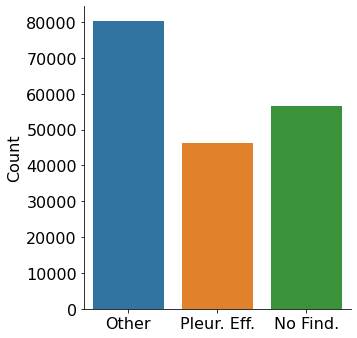

In [38]:
fig = sns.catplot(x='disease', order=['Other', 'Pleur. Eff.', 'No Find.'], data=df_cxr, kind='count')
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.show()
# fig.savefig("MIMIC-pathology.png", bbox_inches='tight', dpi=300)

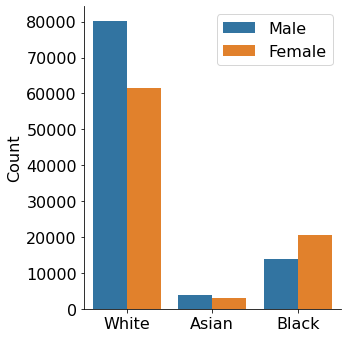

In [39]:
fig = sns.catplot(x='race', hue='sex', order=['White', 'Asian', 'Black'], hue_order=['Male', 'Female'], data=df_cxr, kind='count')
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()
# fig.savefig("MIMIC-sex-race.png", bbox_inches='tight', dpi=300)

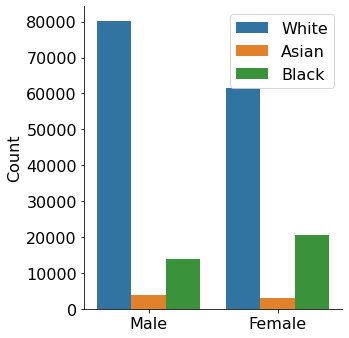

In [40]:
fig = sns.catplot(x='sex', hue='race', order=['Male', 'Female'], hue_order=['White', 'Asian', 'Black'], data=df_cxr, kind='count')
fig._legend.remove()
plt.xlabel('', fontsize=fontsize)
plt.ylabel('Count', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()
# fig.savefig("MIMIC-race-sex.png", bbox_inches='tight', dpi=300)